In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platypus
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from dike_model_function import *

from dike_model_optimization import *
from problem_formulation import *
import time
from ema_workbench import Policy, perform_experiments, Scenario
from ema_workbench import ema_logging
from ema_workbench import MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)

from analysis import *
from ema_workbench import ema_logging
from ema_workbench.analysis import prim
ema_logging.log_to_stderr(ema_logging.INFO)

import functools

## Standard problem formulation

In [3]:
# from problem_formulation import get_model_for_problem_formulation

# model = get_model_for_problem_formulation(1)

## problem formulation

In [3]:
function = DikeNetwork()
# workbench model:
dike_model = Model('dikesnet', function=function)

# Uncertainties and Levers:
# Specify uncertainties range:
Real_uncert = {'Bmax': [30, 350], 'pfail': [0, 1]}  # m and [.]
# breach growth rate [m/day]
cat_uncert_loc = {'Brate': (0.9, 1.5, 1000)}

cat_uncert = {'discount rate': (1.5, 2.5, 3.5, 4.5)}
Int_uncert = {'A.0_ID flood wave shape': [0, 132]}

# Range of dike heightening:
dike_lev = {'DikeIncrease': [0,10]}     # dm

# Series of five Room for the River projects:
rfr_lev = ['{}_RfR'.format(project_id) for project_id in range(0, 5)]

# Time of warning: 0, 1, 2, 3, 4 days ahead from the flood
EWS_lev = {'EWS_DaysToThreat': [0, 3]}  # days

uncertainties = []
levers = []

for dike in function.dikelist:
    # uncertainties in the form: locationName_uncertaintyName
    for uncert_name in Real_uncert.keys():
        name = "{}_{}".format(dike, uncert_name)
        lower, upper = Real_uncert[uncert_name]
        uncertainties.append(RealParameter(name, lower, upper))

    for uncert_name in cat_uncert_loc.keys():
        name = "{}_{}".format(dike, uncert_name)
        categories = cat_uncert_loc[uncert_name]
        uncertainties.append(CategoricalParameter(name, categories))

    # location-related levers in the form: locationName_leversName
    for lev_name in dike_lev.keys():
        name = "{}_{}".format(dike, lev_name)
        levers.append(IntegerParameter(name, dike_lev[lev_name][0],
                                       dike_lev[lev_name][1]))

for uncert_name in cat_uncert.keys():
    categories = cat_uncert[uncert_name]
    uncertainties.append(CategoricalParameter(uncert_name, categories))

# project-related levers can be either 0 (not implemented) or 1
# (implemented)
for uncert_name in Int_uncert.keys():
    uncertainties.append(IntegerParameter(uncert_name, Int_uncert[uncert_name][0],
                                          Int_uncert[uncert_name][1]))
    
# RfR levers can be either 0 (not implemented) or 1 (implemented)
for lev_name in rfr_lev:
    levers.append(IntegerParameter(lev_name, 0, 1))

# Early Warning System lever
for lev_name in EWS_lev.keys():
    levers.append(IntegerParameter(lev_name, EWS_lev[lev_name][0],
                                   EWS_lev[lev_name][1]))

# load uncertainties and levers in dike_model:
dike_model.uncertainties = uncertainties
dike_model.levers = levers

# Problem formulations:
# Outcomes are all costs, thus they have to minimized:
direction = ScalarOutcome.MINIMIZE

# 7 Objectives
# dikes_variable_names = []
# dikes_variable_names.extend(['{}_{}'.format(dike, e) for e in ['Expected Annual Damage', 'Dike Investment Costs']])
# dikes_variable_names.extend(['RfR Total Costs'])
# dikes_variable_names.extend(['Expected Evacuation Costs'])
        
dike_model.outcomes = [
    ScalarOutcome('Expected Number of Deaths',
        variable_name=['{}_Expected Number of Deaths'.format(dike)
            for dike in function.dikelist],
            function=sum_over, kind=direction),
       
    ScalarOutcome('Expected Evacuation Costs', kind=direction),
        
    ScalarOutcome('Expected Annual Damage', 
        variable_name=['{}_Expected Annual Damage'.format(dike)
            for dike in function.dikelist],
            function=sum_over, kind=direction),
    
    ScalarOutcome('Total Construction Costs', 
        variable_name=['{}_Dike Investment Costs'.format(dike) 
            for dike in function.dikelist] + ['RfR Total Costs'],
            function=sum_over, kind=direction)]


[MainProcess/INFO] model initialized


## Random Policies
the fundamental problem is fine tuning the robustness functions. To do this, rather than run optimizaitons many times, why not first generate a test set with a bunch of policies, apply robustness functions and visualize the results?

This gives us much faster feedback on reasonble cutoff values

In [11]:
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=300,              
                                            policies=150) 
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 300 scenarios * 150 policies * 1 model(s) = 45000 experiments
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 13500 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 22500 cases completed
[MainProcess/INFO] 27000 cases completed
[MainProcess/INFO] 31500 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] 40500 cases completed
[MainProcess/INFO] 45000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Processing time : 61.73616290092468 Minutes


In [3]:
# from ema_workbench import save_results

# save_results(results, r'./100pol200sce.tar.gz')
#from ema_workbench import load_results

#results = load_results('100pol200sce.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\HP EliteBook 8560p\Dropbox\EPA\EPA1361 Model-Based Decision-making\epa1361_open-master\final assignment\100pol200sce.tar.gz


In [25]:
# df_outcomes = pd.read_csv("Random_Policies_results_50k_run.csv") 
# df_experiments = pd.read_csv("Random_Policies_experiments_data_50k_run.csv")
# outcomes = df_outcomes.drop('Unnamed: 0', axis=1)
# experiments = df_experiments.drop('Unnamed: 0', axis=1)
#experiments, outcomes = results
#outcomes
#experiments = experiments.values
#df_outcomes

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


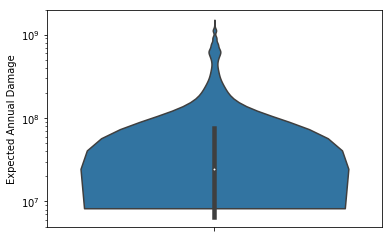

In [34]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Annual Damage')
ax.set_yscale('log')
plt.show()

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


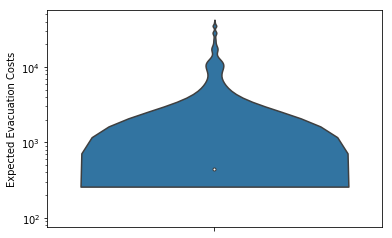

In [35]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Evacuation Costs')
ax.set_yscale('log')
plt.show()

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


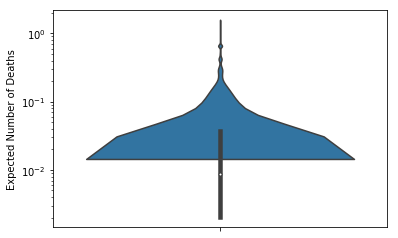

In [36]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Number of Deaths')
ax.set_yscale('log')
plt.show()

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


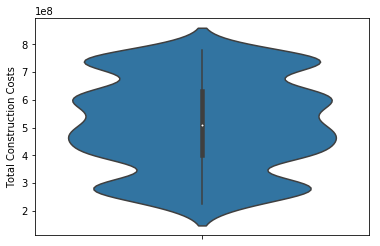

In [37]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(data=data, y='Total Construction Costs')
plt.show()

In [30]:
# df_outcomes = pd.DataFrame(outcomes)
print("avg Expected Annual Damage: ", outcomes['Expected Annual Damage'].mean() ) 
print("avg Expected Evacuation Costs: ", outcomes['Expected Evacuation Costs'].max() )
print("avg Total Construction Costs: ", outcomes['Total Construction Costs'].mean() )
print("avg Expected Number of Deaths: ", outcomes['Expected Number of Deaths'].mean() )
#df_outcomes.head()

# print("95th percentile Expected Annual Damage:", outcomes['Expected Annual Damage'].quantile(0.05) ) # 95th percentile
# print("95th percentile Expected Evacuation Costs: ", outcomes['Expected Evacuation Costs'].quantile(0.05) )
# print("95th percentile Total Construction Costs: ", outcomes['Total Construction Costs'].quantile(0.05) )
#print("95th percentile Expected Number of Deaths: ", pd.DataFrame(outcomes['Expected Number of Deaths']).quantile(0.95)  )
#experiments.head()

# outcomes['Expected Number of Deaths'].hist(bins = 500)
# plt.show()
# experiments

avg Expected Annual Damage:  81214048.11089651
avg Expected Evacuation Costs:  52393.78979228189
avg Total Construction Costs:  508814192.2685393
avg Expected Number of Deaths:  0.04226472003077054


## Robustness

In [9]:
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def costs(data):
    return data[0]/1e9 # makes numbers nicer(kwakkel)
    
SMALLER = 'SMALLER'

## Input values to minimize
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.001) 
Expected_Evacuation_Costs = functools.partial(robustness, SMALLER, 10000)
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 250000)
Total_Construction_Costs = costs

D:\Applications\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\Applications\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


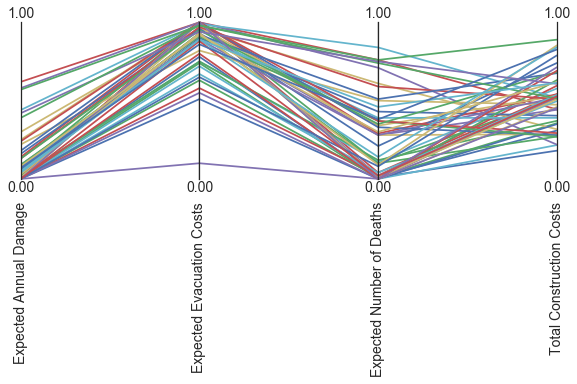

In [7]:
from ema_workbench.analysis import parcoords

#experiments, outcomes = results

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Evacuation Costs': Expected_Evacuation_Costs,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Construction Costs': Total_Construction_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()


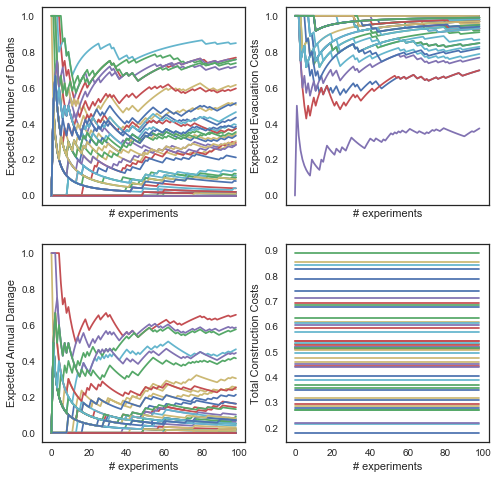

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

robustness_funcs = {"Expected Number of Deaths": Expected_Number_of_Deaths,
                    "Total Construction Costs": Total_Construction_Costs,
                    "Expected Evacuation Costs": Expected_Evacuation_Costs,
                    "Expected Annual Damage": Expected_Annual_Damage }

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
        # data.shape should be (500,), given n_scenarios=500
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)
    
plt.show()

In [20]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Evacuation Costs': Expected_Evacuation_Costs,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Construction Costs': Total_Construction_Costs}

robustnes_functions = [ScalarOutcome('fraction Expected Number of Deaths', kind=MAXIMIZE, 
                             variable_name='Expected Number of Deaths', function=Expected_Number_of_Deaths),
                       ScalarOutcome('fraction Expected Evacuation Costs', kind=MAXIMIZE, 
                             variable_name='Expected Evacuation Costs', function=Expected_Evacuation_Costs),
                       ScalarOutcome('fraction Expected Annual Damage', kind=MAXIMIZE, 
                             variable_name='Expected Annual Damage', function=Expected_Annual_Damage),
                       ScalarOutcome('raw Total Construction Costs', kind=MINIMIZE, # note that we have to minimize costs!
                             variable_name='Total Construction Costs', function=Total_Construction_Costs)]

In [12]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 30
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = int(6000)

In [15]:
# we have to change the plausible max for total investment costs
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                            perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                      EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1

ema_logging.log_to_stderr(ema_logging.INFO)
convergence = [HyperVolume(minimum=[0,0,0,0], maximum=[1.1, 1.1, 1.1, 3]),
              EpsilonProgress()]

#epsilons=[0.05,]*len(robustnes_functions)
epsilonlist = [0.001,100,1e3,1e4]

start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios,nfe=nfe,
                                                     convergence=convergence, epsilons=epsilonlist)
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] terminating pool


NameError: name 'robustnes_functions' is not defined

### Check if hypervolume is stable (flattening out)

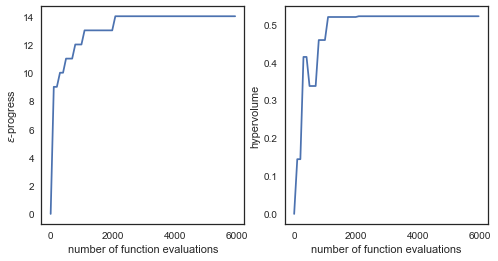

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Trade-offs and (conflicting) objectives

In [13]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

NameError: name 'archive' is not defined

In [ ]:
data

In [ ]:
archive

In [54]:
data.to_csv("MORO_data2.csv")
archive.to_csv("MORO_archive2.csv")
convergence.to_csv("MORO_convergence2.csv")

## Comparing MORO runs


In [ ]:
# pre-defined policy based on optimization
def levers_parameter (Dike_1 = 0, Dike_2 = 0,Dike_3 = 0,Dike_4 = 0,Dike_5 = 0, 
                      rfr_0 = 0, rfr_1 = 0, rfr_2 = 0, rfr_3 = 0, rfr_4 = 0,
                      EWS = 0) :
    
    levers_param = {'A.1_DikeIncrease': Dike_1, 'A.2_DikeIncrease': Dike_2, 'A.3_DikeIncrease': Dike_3, 
                  'A.4_DikeIncrease': Dike_4, 'A.5_DikeIncrease': Dike_5,
                  '0_RfR': rfr_0, '1_RfR': rfr_1, '2_RfR': rfr_2, '3_RfR': rfr_3, '4_RfR': rfr_4,
                  'EWS_DaysToThreat': EWS}
    
    return levers_param
# Policy from with lowest 'Expected Number of Deaths'
# Policy from MORDM Worst case scenario
policy_1a = Policy("Policy_MORO_1A", **levers_parameter(6,9,9,10,9,0,0,0,0,0,))
policy_1b = Policy("Policy_MORO_1B", **levers_parameter(8,10,9,10,9,0,0,0,0,0,3))
#policy_1c = Policy("Policy_MORDM_C", **levers_parameter(3,6,5,3,9,0,0,1,0,0,2)) 

# Policy from with lowest 'All Costs'
# Policy from MORO case scenario
policy_2a = Policy("Policy_MORO_2A", **levers_parameter(8,8,10,9,10,0,0,0,0,0,3))
policy_2b = Policy("Policy_MORO_2B", **levers_parameter(6,7,10,8,10,0,0,0,0,0,3)) 

policy_3a = Policy("Policy_MORO_3A", **levers_parameter(7,8,9,5,9,0,0,0,1,0,3))
policy_3b = Policy("Policy_MORO_3B", **levers_parameter(7,7,10,8,10,0,0,0,0,0,3))
policy_3c = Policy("Policy_MORO_3C", **levers_parameter(7,6,10,7,9,0,0,0,0,0,3))

# number scenarios
n_scenarios = 2000

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, [#policy_0,policy_max
                                                          policy_1a,policy_1b,#policy_1c
                                                          policy_2a,policy_2b,
                                                          policy_3a,policy_3b,policy_3c
                                                          #policy_lever_deaths,
                                                          #policy_lever_cost,
                                                          #policy_dikes,policy_rfr,
                                                          ])
    
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')
experiments, outcomes = results
dfexperiment = pd.DataFrame(data=experiments)
dfoutput = pd.DataFrame(data=outcomes)

dfoutput['policy'] = dfexperiment['policy']

sns.pairplot(dfoutput, hue='policy',  vars=dfoutput.columns.drop('policy'), )

plt.show()

In [ ]:
df_moro_results_mean = dfoutput.groupby(['policy']).mean()
df_moro_results_mean.sort_values('Expected Number of Deaths')

# df_moro_results_max = dfoutput.groupby(['policy']).max()
# df_moro_results_max.sort_values('Expected Number of Deaths')

# df_moro_results_min = dfoutput.groupby(['policy']).min()
# df_moro_results_min.sort_values('Expected Number of Deaths')